In [44]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

START_SUBCARRIER = 132
END_SUBCARRIER = 246

amplitudes_queue = []
phases_queue = []

def compute_csi_amplitude_phase(csi_data):
    amplitudes = []
    phases = []
    
    # Ensure the data length is even (pairs of I and Q)
    if len(csi_data) % 2 != 0:
        raise ValueError('CSI data length must be even (pairs of I and Q values).')
    
    for i in range(0, len(csi_data), 2):
        I = csi_data[i]
        Q = csi_data[i + 1]
        
        amplitude = math.sqrt(I**2 + Q**2)
        phase = math.atan2(Q, I)
        
        amplitudes.append(amplitude)
        phases.append(phase)
    
    amplitudes_queue.append(amplitudes)
    phases_queue.append(phases)

def plot_amp_phase(csv_file_path):
    try:
        # Convert string list to actual list
        csi_df = pd.read_csv(csv_file_path)
        raw_csi = csi_df['Raw_CSI'].apply(eval)

        for csi_data in raw_csi:
            compute_csi_amplitude_phase(csi_data[START_SUBCARRIER:END_SUBCARRIER])
    except KeyError:
        print("Error: 'Amplitude' or 'Phase' column not found in the file.")
        return

    plt.figure(figsize=(8, 10))
    ax = plt.axes(projection='3d')
    
    for amp, phase in zip(amplitudes_queue, phases_queue):
        # This loop ensures that each subcarrier is plot in the same x-axis
        x = np.arange(len(phase))
        y = np.array(phase)
        z = np.array(amp)
        ax.scatter(x, y, z, c=z, cmap='coolwarm', marker='o')

    plt.title("3D Scatter Plot: Baseline")
    ax.set_xlabel("Subcarrier")
    ax.set_ylabel("Phase (radians)")
    ax.set_zlabel("Amplitude")
    plt.show()

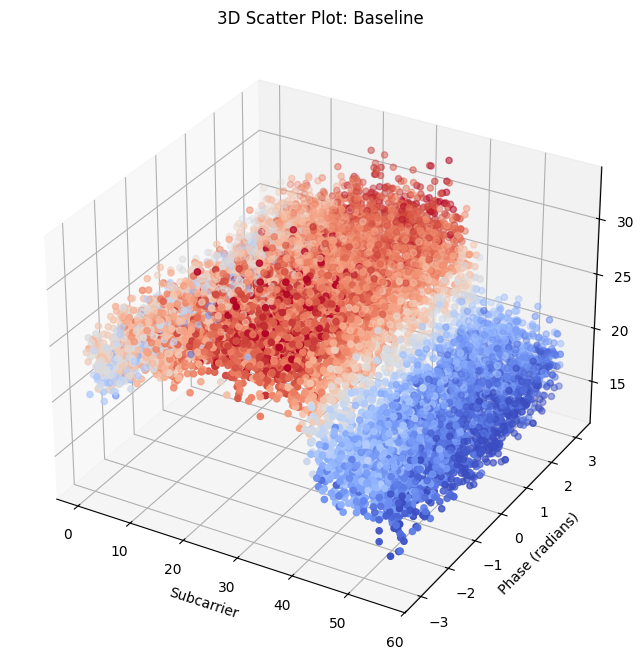

In [45]:
csv_file_path = '../dataset/s2_orig/CSI_DATA_110.csv'

plot_amp_phase(csv_file_path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

recording = True
monitoring = False
csv_file_path = None
amplitude_queue = []
phase_queue = []
cutoff_frequency = 0.1  # Adjust the cutoff frequency as needed
sampling_rate = 1.0  # Adjust the sampling rate as needed

def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def filter_amp_phase_highpass():
    filtered_positions = []

    if monitoring:
        csi_amplitude = amplitude_queue
        csi_phase = phase_queue
    else:
        try:
            # Convert string list to actual list
            csi_df = pd.read_csv(csv_file_path)
            csi_amplitude = csi_df['Amplitude'].apply(eval)
            csi_phase = csi_df['Phase'].apply(eval)
        except KeyError:
            print("Error: 'Amplitude' or 'Phase' column not found in the file.")
            return

    # Apply high-pass filter to amplitude and phase data
    csi_amplitude = csi_amplitude.apply(lambda x: highpass_filter(np.array(x), cutoff_frequency, sampling_rate))
    csi_phase = csi_phase.apply(lambda x: highpass_filter(np.array(x), cutoff_frequency, sampling_rate))

    plt.figure(figsize=(8, 10))
    ax = plt.axes(projection='3d')
    
    for amp, phase in zip(csi_amplitude, csi_phase):
        amp = np.array(amp)
        phase = np.array(phase)

        # This loop ensures that each subcarrier is plot in the same x-axis
        x = np.arange(len(phase))
        y = phase
        z = amp
        ax.scatter(x, y, z, c=z, cmap='coolwarm', marker='o')

        for i in range(len(x)):
            if z[i] == 0:
                continue
            filtered_positions.append((float(x[i]), float(y[i]), float(z[i])))
    
    plt.title("3D Scatter Plot: With High Pass Filter")
    ax.set_xlabel("Subcarrier")
    ax.set_ylabel("Phase (radians)")
    ax.set_zlabel("Amplitude")
    plt.show()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_statistics():
    csi_df = pd.read_csv(csv_file_path)

    amplitude = csi_df['Amplitude'].apply(eval)
    # phase = csi_df['Phase'].apply(eval)

    amps_transposed = list(map(list, zip(*amplitude)))
    # phases_transposed = list(map(list, zip(*phase)))

    # Calculate mean and standard deviation for each subcarrier
    means = np.mean(amps_transposed, axis=1)
    std_devs = np.std(amps_transposed, axis=1)

    # Create a DataFrame for easier sorting
    stats_df = pd.DataFrame({
        'Subcarrier': np.arange(len(means)),
        'Mean': means,
        'Standard Deviation': std_devs
    })

    # Sort by standard deviation
    # stats_df = stats_df.sort_values(by='Standard Deviation', ascending=False)

    # Plot the values
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(stats_df))

    bar1 = ax.bar(index, stats_df['Mean'], bar_width, label='Mean')
    bar2 = ax.bar(index + bar_width, stats_df['Standard Deviation'], bar_width, label='Standard Deviation')

    ax.set_xlabel('Subcarrier')
    ax.set_ylabel('Value')
    ax.set_title('Mean and Standard Deviation of Subcarriers')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(stats_df['Subcarrier'])
    ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
csv_file_path = '../dataset/s2_orig/CSI_DATA_110.csv'
filter_amp_phase_baseline()

cutoff_frequency = 0.1
sampling_rate = 1.0
filter_amp_phase_highpass()

# plot_statistics()

Error: 'Amplitude' or 'Phase' column not found in the file.
Error: 'Amplitude' or 'Phase' column not found in the file.


In [19]:
# from scipy.stats import zscore

# def detect_anomalies(csi_amplitude, threshold=8):
#     # Flatten the amplitude data for anomaly detection
#     flattened_amplitude = np.concatenate(csi_amplitude.values)

#     # Calculate the Z-scores of the amplitude data
#     z_scores = zscore(flattened_amplitude)

#     # Identify indices where the Z-score exceeds the threshold
#     anomaly_indices = np.where(np.abs(z_scores) > threshold)[0]

#     # Print the packet indices that contain anomalies
#     for idx in anomaly_indices:
#         packet_index = idx // len(csi_amplitude.iloc[0])
#         print(f"Anomaly detected in packet index: {packet_index}")

# csi_amplitude = pd.read_csv('room_near.csv')['CSI_Amplitude'].apply(eval)
# detect_anomalies(csi_amplitude)

In [ ]:
import pandas as pd

def parse_csi_data(data_str):
    # parts = data_str.split(',')
    # csi_data_start = data_str.find('[')
    # csi_data_end = data_str.find(']')

    # Extract CSI data as a string of integers
    # csi_data = data_str[csi_data_start + 1:csi_data_end].strip().split(' ')
    # csi_data = list(filter(None, csi_data))  # Remove empty strings
    csi_data = pd.read_csv('CSI_DATA_004.csv')['Raw_CSI'].apply(eval).tolist()

    try:
        # csi_data = [int(x) for x in csi_data]
        amplitudes, phases = compute_csi_amplitude_phase(csi_data)
    except ValueError:
        csi_data, amplitudes, phases = [], [], []

    return parts[:25] + [csi_data, amplitudes, phases]